# Question: How does the frequency of crimes by race group affect average sentence in years for the top 10 Texas metro counties and top 5 offenses?


# Import Dependencies

In [617]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
from datetime import datetime
import gmaps
import os
pd.set_option('display.max_row', 1000)
%matplotlib inline
import seaborn as sb
import matplotlib.ticker as ticker

#Import mother_ship database from Exploration and Cleanup file
%store -r mother_ship

In [618]:
mother_ship.head()

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat,Age_Bin,Population_2020
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/1/2020,11/15/2025,9/26/2018,...,12/14/2017,9/13/2017,8,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80,131710
1,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,4/21/2028,3/11/2043,10/20/2020,...,3/12/2018,3/31/2017,25,Denied on 08/13/2020,21-Aug,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80,131710
2,1505838,2119905,"PENNINGTON,RICKEY DWAYNE",Pack,M,W,68,12/21/2028,12/21/2028,4/11/2018,...,2/8/2017,12/21/2016,12,Denied on 01/02/2020,20-Dec,IN PAROLE REVIEW PROCESS,2200,Drugs,60_to_70,131710
3,2141308,2153019,"JACOBS,ANTHONY",Ellis,M,W,64,12/18/2023,6/14/2033,2/28/2019,...,7/27/2017,10/11/2016,16,Denied on 02/19/2020,21-Feb,NOT IN REVIEW PROCESS,2200,Drugs,60_to_70,131710
4,2360914,2290868,"WALDEN,LONNIE WAYNE",Gurney,M,W,62,4/2/2033,5/28/2049,NaN,...,10/24/2019,5/29/2019,30,None,Unavailable at this time.,NOT IN REVIEW PROCESS,2200,Drugs,60_to_70,131710


In [655]:
date = mother_ship[['Offense_Date', 'Race']]
date. sort_values( by = 'Offense_Date')

,Offense_Date,Race
85783,1/1/1984,W
53041,1/1/1984,B
43343,1/1/1984,W
100078,1/1/1985,W
108230,1/1/1988,B
...,...,...
104265,9/9/2019,B
26033,9/9/2019,H
39980,9/9/2019,B
77102,9/9/2019,W


In [619]:
# Income by county and race
income_pd = pd.read_csv('../Resources/Income_by_Location.csv')
income_pd['Household Income by Race'] = income_pd['Household Income by Race'].astype(int)

In [620]:
income_pivot = pd.pivot_table(income_pd, index = 'Geography', columns = 'Race', values = 'Household Income by Race')
income_pivot

Race,Asian,Black,Hispanic,Other,White
Geography,,,,,
Bexar,75781,44964,46329,56894,62532
Collin,118264,72508,63312,92271,99948
Dallas,80415,43717,51473,63822,73737
Denton,100787,63556,70075,76802,93735
El Paso,52181,62616,39744,38952,53994
Fort Bend,113902,76890,61961,90703,103495
Harris,74974,42774,49270,60634,78901
Hidalgo,51350,58561,37549,45677,45671
Tarrant,72681,47885,55035,63620,77840


# Data Cleanup

In [621]:
# Pick off columns from mother_ship for Bin Category, County, and Offense Category
rate_df = mother_ship.loc[:,['County','Bin_Cat','Offense_Category','Sentence_Years', 'Age','Race']]
rate_df.rename(columns = {'Offense_Category': 'Offense_Count'}, inplace = 'TRUE')
rate_df['County'] = rate_df['County'].astype('category')

In [622]:
# Replace raceabbreviations with full names
rate_df = rate_df.replace(to_replace='W', value = "White")
rate_df = rate_df.replace(to_replace='B', value = "Black")
rate_df = rate_df.replace(to_replace='H', value = "Hispanic")
rate_df = rate_df.replace(to_replace='A', value = "Asian")
rate_df = rate_df.replace(to_replace='I', value = "Indian")
rate_df = rate_df.replace(to_replace='U', value = "Other")
rate_df = rate_df.replace(to_replace='O', value = "Other")

In [623]:
# Calculate sentence years errors
rate_df=rate_df.replace(to_replace="Life",value="50.9")
rate_df=rate_df.replace(to_replace="LWOP", value="100.9")
rate_df=rate_df.replace(to_replace="Capital Life", value = "101.9") 
rate_df=rate_df.replace(to_replace="Death", value = "150.9")

# Change date format to sentence
rate_df=rate_df.replace(to_replace="2024.9",value="6.0")
rate_df=rate_df.replace(to_replace="2092.7", value="8.0")
rate_df=rate_df.replace(to_replace="2027.0", value = "10.0") 
rate_df=rate_df.replace(to_replace="2026.4", value = "11.0")
rate_df=rate_df.replace(to_replace="2027.1",  value = "10.0")
rate_df=rate_df.replace(to_replace="2024.8",value="6.0")
rate_df=rate_df.replace(to_replace="2024.7", value="7.0")
rate_df=rate_df.replace(to_replace="2023.5", value = "5.0") 
rate_df=rate_df.replace(to_replace="2026.3", value = "8.0")
rate_df=rate_df.replace(to_replace="2020.8",  value = "5.0")
rate_df=rate_df.replace(to_replace="2022.4",value="8.0")
rate_df=rate_df.replace(to_replace="2019.8", value="10.0")
rate_df=rate_df.replace(to_replace="2022.2", value = "5.0") 
rate_df=rate_df.replace(to_replace="2024.0", value = "6.0")
rate_df=rate_df.replace(to_replace="2029.9",  value = "10.0")
rate_df=rate_df.replace(to_replace="2022.3",value="6.0")
rate_df=rate_df.replace(to_replace="2027.9", value="8.0")
rate_df=rate_df.replace(to_replace="2023.4", value = "6.0") 
rate_df=rate_df.replace(to_replace="2021.4", value = "6.0")
rate_df=rate_df.replace(to_replace="2021.5",value="2.0")
rate_df=rate_df.replace(to_replace="2022.9", value="3.0")
rate_df=rate_df.replace(to_replace="2022.8", value = "4.0") 
rate_df=rate_df.replace(to_replace="2023.0", value = "5.0")
rate_df=rate_df.replace(to_replace="2024.3",  value = "6.0")
rate_df=rate_df.replace(to_replace="2021.6",value="4.0")
rate_df=rate_df.replace(to_replace="2021.2", value="5.0")
rate_df=rate_df.replace(to_replace="2022.7", value = "5.0") 
rate_df=rate_df.replace(to_replace="2023.9", value = "4.0")
rate_df=rate_df.replace(to_replace="2025.1",  value = "9.0")
rate_df=rate_df.replace(to_replace="2020.5",value="1.0")
rate_df=rate_df.replace(to_replace="2019.5", value="4.0")
rate_df=rate_df.replace(to_replace="2029.5", value = "10.0") 
rate_df=rate_df.replace(to_replace="2021.9", value = "10.0")
rate_df=rate_df.replace(to_replace="2025.0",  value = "6.0")
rate_df=rate_df.replace(to_replace="2024.5",value="5.0")
rate_df=rate_df.replace(to_replace="2022.6", value="3.0")
rate_df=rate_df.replace(to_replace="2020.2", value = "2.0") 
rate_df=rate_df.replace(to_replace="2030.0", value = "11.0")
rate_df=rate_df.replace(to_replace="2023.6",  value = "5.0")
rate_df=rate_df.replace(to_replace="2024.2",value="6.0")
rate_df=rate_df.replace(to_replace="2029.7",  value = "8.0")
rate_df=rate_df.replace(to_replace="2020.9",value="2.0")


In [624]:
# Clean up sentence years
rate_df = rate_df.astype({'Sentence_Years': float})
rate_df.loc[(rate_df.Sentence_Years >= 160),'Sentence_Years']=150.9

In [625]:
# Fill in NaN values to zero
rate_df['Offense_Count'].fillna(value = 0, inplace = True)
rate_df['Sentence_Years'].fillna(value = 0, inplace = True)

# Aggregation and Grouping

In [626]:
# Bring in Race Population Data
race_pop = pd.read_csv('../Resources/Race_Population.csv')
land_df = pd.read_csv('../Resources/Texas_Land_Area_Data.csv')

In [627]:
land_metro_df = land_df[land_df.County.isin(['Bexar', 'Collin', 'Dallas', 'Denton', 'El Paso', 'Fort Bend',
       'Harris', 'Hidalgo', 'Tarrant', 'Travis'])]
land_metro = land_metro_df.set_index('County')

In [628]:
# Add in race population to metro_frame
metro= rate_df.merge(race_pop, how = 'inner', left_on= ['County', 'Race'], right_on= ['County','Race'])

In [629]:
# Filter for top 10 counties and top 5 offenses
metro_df = metro[metro.Bin_Cat.isin(['Murder', 'Sexual_Assault','Assault','Robbery','Drugs'])]

In [630]:
# grouby County and Bin Category; get count of Offense Count
metro_frame = metro_df.groupby(['County','Bin_Cat','Race'])[['Offense_Count','Sentence_Years','Population']] \
                .agg({'Offense_Count': 'count', 'Sentence_Years':'mean', 'Population': 'mean'})

metro_frame['Offense_per_1000'] = metro_frame['Offense_Count'] / metro_frame['Population'] * 1000
metro_frame = metro_frame.dropna()

In [631]:
# Delete Unneeded rows and change data types
del metro_frame['Offense_Count']
del metro_frame['Population']

# Plotting

In [632]:
# Set up grouped bar chart for each of the top 5 bin categories
murder_df = metro_frame.query('Bin_Cat == "Murder"')
robbery_df = metro_frame.query('Bin_Cat == "Robbery"')
sexassault_df = metro_frame.query('Bin_Cat == "Sexual_Assault"')
assault_df = metro_frame.query('Bin_Cat == "Assault"')
drugs_df = metro_frame.query('Bin_Cat == "Drugs"')

In [633]:
# Reset indices
murder_df = murder_df.reset_index()
robbery_df = robbery_df.reset_index()
sexassault_df = sexassault_df.reset_index()
drugs_df = drugs_df.reset_index()
assault_df = assault_df.reset_index()


In [634]:
murder_df

,County,Bin_Cat,Race,Sentence_Years,Offense_per_1000
0,Bexar,Murder,Asian,56.160000,0.078077
1,Bexar,Murder,Black,52.900692,1.881523
2,Bexar,Murder,Hispanic,47.380843,0.617629
3,Bexar,Murder,Other,32.000000,0.066618
4,Bexar,Murder,White,49.475000,0.340982
5,Collin,Murder,Asian,74.437500,0.051480
6,Collin,Murder,Black,51.041304,0.433243
7,Collin,Murder,Hispanic,64.188571,0.210388
8,Collin,Murder,Other,84.600000,0.089429
9,Collin,Murder,White,55.776623,0.133244


In [635]:
murder_df.County.unique()

array(['Bexar', 'Collin', 'Dallas', 'Denton', 'El Paso', 'Fort Bend',
       'Harris', 'Hidalgo', 'Tarrant', 'Travis'], dtype=object)

In [636]:
# Delete unnecessary Bin Cat column
del murder_df['Bin_Cat']
del robbery_df['Bin_Cat']
del sexassault_df['Bin_Cat']
del drugs_df['Bin_Cat']
del assault_df['Bin_Cat']
del murder_df['Sentence_Years']
del robbery_df['Sentence_Years']
del sexassault_df['Sentence_Years']
del drugs_df['Sentence_Years']
del assault_df['Sentence_Years']

In [637]:
# Create Pivot charts
murder_pivot = pd.pivot_table(murder_df,index='County',columns='Race',values='Offense_per_1000', margins=  True,margins_name= 'Total', aggfunc = 'sum')
robbery_pivot = pd.pivot_table(robbery_df,index='County',columns='Race',values='Offense_per_1000', margins=  True,margins_name= 'Total', aggfunc = 'sum')
sexassault_pivot = pd.pivot_table(sexassault_df,index='County',columns='Race',values='Offense_per_1000', margins=  True,margins_name= 'Total', aggfunc = 'sum')
drugs_pivot = pd.pivot_table(drugs_df,index='County',columns='Race',values='Offense_per_1000', margins=  True,margins_name= 'Total', aggfunc = 'sum')
assault_pivot = pd.pivot_table(assault_df,index='County',columns='Race',values='Offense_per_1000', margins=  True,margins_name= 'Total', aggfunc = 'sum')

In [638]:
# Sort pivot charts
murder_pivot = murder_pivot.sort_values('Total' , ascending=False)
murder_pivot = murder_pivot[murder_pivot.sum().sort_values(ascending = False).index]
del murder_pivot['Total']
murder_pivot = murder_pivot.drop(['Total'])

robbery_pivot = robbery_pivot.sort_values('Total' , ascending=False)
robbery_pivot = robbery_pivot[robbery_pivot.sum().sort_values(ascending = False).index]
del robbery_pivot['Total']
robbery_pivot = robbery_pivot.drop(['Total'])

sexassault_pivot = sexassault_pivot.sort_values('Total' , ascending=False)
sexassault_pivot = sexassault_pivot[sexassault_pivot.sum().sort_values(ascending = False).index]
del sexassault_pivot['Total']
sexassault_pivot = sexassault_pivot.drop(['Total'])

drugs_pivot = drugs_pivot.sort_values('Total' , ascending=False)
drugs_pivot = drugs_pivot[drugs_pivot.sum().sort_values(ascending = False).index]
del drugs_pivot['Total']
drugs_pivot = drugs_pivot.drop(['Total'])

assault_pivot = assault_pivot.sort_values('Total' , ascending=False)
assault_pivot = assault_pivot[assault_pivot.sum().sort_values(ascending = False).index]
del assault_pivot['Total']
assault_pivot = assault_pivot.drop(['Total'])


In [639]:
murder_pivot

Race,Black,Hispanic,White,Other,Asian
County,,,,,
Dallas,2.052652,0.485932,0.358065,0.246240,0.073781
Bexar,1.881523,0.617629,0.340982,0.066618,0.078077
Harris,1.724748,0.461718,0.378381,0.304718,0.092824
El Paso,1.357795,0.303896,0.473850,0.068757,0.170097
Tarrant,1.373818,0.316728,0.295619,0.049918,0.071048
Travis,1.372761,0.387476,0.230513,0.029330,0.023263
Hidalgo,0.643501,0.470551,0.262354,0.377786,NaN
Collin,0.433243,0.210388,0.133244,0.089429,0.051480
Fort Bend,0.434332,0.202215,0.105771,0.043486,0.005736


In [640]:
income_pivot = income_pivot[['Black', 'Hispanic', 'White', 'Other', 'Asian']]

In [641]:
metro_frame

Sentence_Years  Offense_per_1000
County    Bin_Cat        Race                                      
Bexar     Murder         Asian          56.160000          0.078077
                         Black          52.900692          1.881523
                         Hispanic       47.380843          0.617629
                         Other          32.000000          0.066618
                         White          49.475000          0.340982
          Sexual_Assault Asian          32.000000          0.062462
                         Black          25.966258          1.061205
                         Hispanic       21.872954          0.664957
                         Other          14.500000          0.088824
                         White          21.352525          0.351638
          Robbery        Asian          11.750000          0.062462
                         Black          20.396977          2.584652
                         Hispanic       17.083787          0.724905
                         White          19.763372          0.305463
          Assault        Asian          13.000000          0.031231
                         Black          13.529021          1.861991
                         Hispanic       10.889083          0.722539
                         White          12.856494          0.273496
          Drugs          Asian           9.000000          0.046846
                         Black          10.306790          1.054694
                         Hispanic        8.347917          0.643659
                         White           7.233526          0.307239
Collin    Murder         Asian          74.437500          0.051480
                         Black          51.041304          0.433243
                         Hispanic       64.188571          0.210388
                         Other          84.600000          0.089429
                         White          55.776623          0.133244
          Sexual_Assault Asian          31.200000          0.057915
                         Black          30.762338          0.725211
                         Hispanic       29.446286          1.051942
                         Other          15.000000          0.059620
                         White          29.219205          0.522594
          Robbery        Black          20.640230          0.819394
                         Hispanic       17.767442          0.258477
                         Other           3.000000          0.029810
                         White          21.123913          0.079600
          Assault        Asian           4.000000          0.019305
                         Black          15.112903          0.583936
                         Hispanic       10.470732          0.246455
                         Other          16.000000          0.029810
                         White          14.104301          0.160931
          Drugs          Asian           9.250000          0.025740
                         Black           8.582222          0.423825
                         Hispanic       11.069697          0.198366
                         White           7.939796          0.169583
Dallas    Murder         Asian          33.264286          0.073781
                         Black          57.593632          2.052652
                         Hispanic       52.023629          0.485932
                         Other          59.535714          0.246240
                         White          55.779928          0.358065
          Sexual_Assault Asian          30.741667          0.063240
                         Black          30.416041          1.418460
                         Hispanic       26.627818          0.766101
                         Other          48.333333          0.052766
                         White          29.146783          0.737947
          Robbery        Asian          12.000000          0.015810
                         Black          24.894848          2.975701
                       

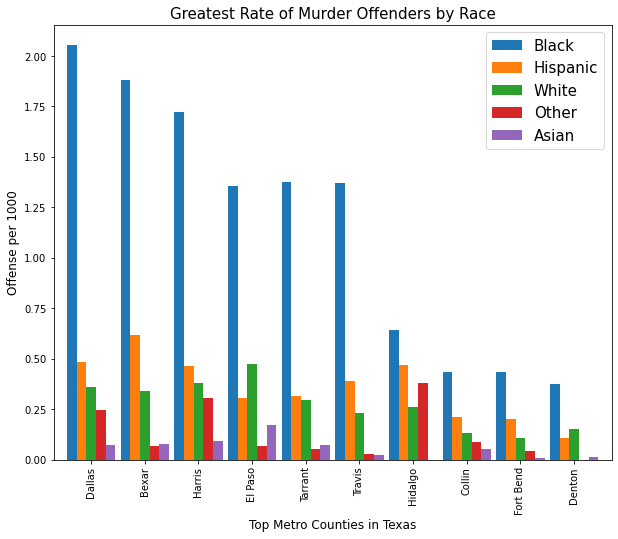

In [530]:
# Murder Plot
width = 0.9
fg = murder_pivot.plot.bar(width = width, figsize = (10,8))
plt.title('Greatest Rate of Murder Offenders by Race', fontsize = '15')
plt.xticks(rotation='vertical')
plt.xlabel('Top Metro Counties in Texas', fontsize = '12')
plt.ylabel('Offense per 1000', fontsize = '12')
plt.legend(loc=1, prop={'size': 15})
plt.savefig('Murder_and_Race.png')

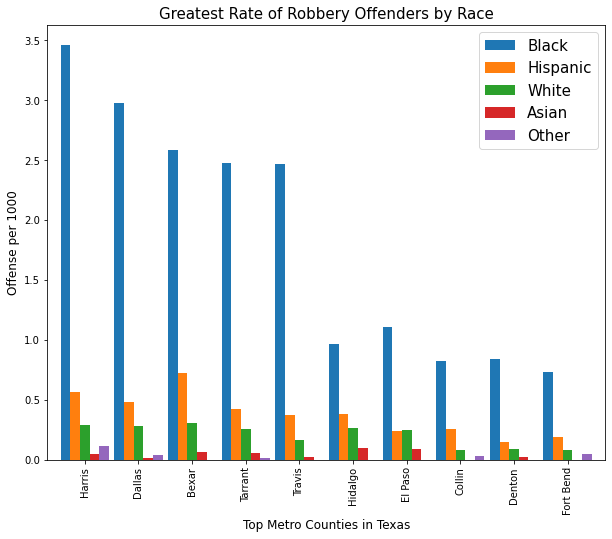

In [531]:
# Robbery Plot
width = 0.9
fg = robbery_pivot.plot.bar(width = width, figsize = (10,8))
plt.title('Greatest Rate of Robbery Offenders by Race', fontsize = '15')
plt.xticks(rotation='vertical')
plt.xlabel('Top Metro Counties in Texas', fontsize = '12')
plt.ylabel('Offense per 1000', fontsize = '12')
plt.legend(loc=1, prop={'size': 15})
plt.savefig('Robbery_and_Race.png')

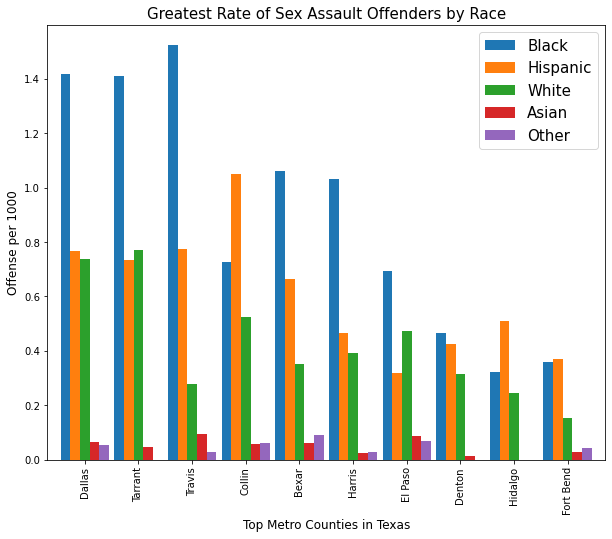

In [532]:
# Sex Assault Plot
width = 0.9
fg = sexassault_pivot.plot.bar(width = width, figsize = (10,8))
plt.title('Greatest Rate of Sex Assault Offenders by Race', fontsize = '15')
plt.xticks(rotation='vertical')
plt.xlabel('Top Metro Counties in Texas', fontsize = '12')
plt.ylabel('Offense per 1000', fontsize = '12')
plt.legend(loc=1, prop={'size': 15})
plt.savefig('SexAssault_and_Race.png')

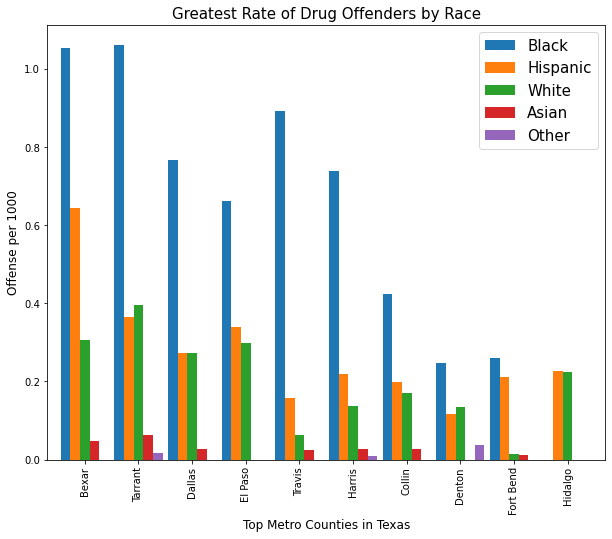

In [533]:
# Drugs Plot
width = 0.9
fg = drugs_pivot.plot.bar(width = width, figsize = (10,8))
plt.title('Greatest Rate of Drug Offenders by Race', fontsize = '15')
plt.xticks(rotation='vertical')
plt.xlabel('Top Metro Counties in Texas', fontsize = '12')
plt.ylabel('Offense per 1000', fontsize = '12')
plt.legend(loc=1, prop={'size': 15})
plt.savefig('Drug_and_Race.png')

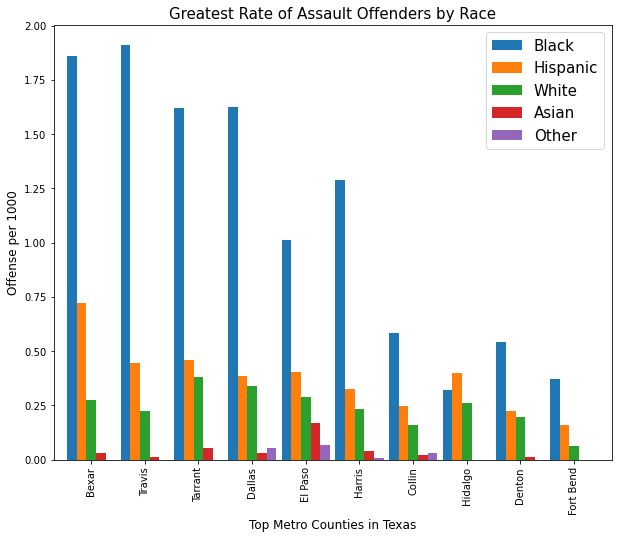

In [534]:
# Assault Plot
width = 0.9
fg = assault_pivot.plot.bar(width = width, figsize = (10,8))
plt.title('Greatest Rate of Assault Offenders by Race', fontsize = '15')
plt.xticks(rotation='vertical')
plt.xlabel('Top Metro Counties in Texas', fontsize = '12')
plt.ylabel('Offense per 1000', fontsize = '12')
plt.legend(loc=1, prop={'size': 15})
plt.savefig('Assault_and_Race.png')

In [535]:
# Incorporate Income
murder_income = murder_df.merge(income_pd, how = 'inner', left_on= ['County', 'Race'], right_on= ['Geography','Race'])
robbery_income = robbery_df.merge(income_pd, how = 'inner', left_on= ['County', 'Race'], right_on= ['Geography','Race'])
sexassault_income = sexassault_df.merge(income_pd, how = 'inner', left_on= ['County', 'Race'], right_on= ['Geography','Race'])
drugs_income = drugs_df.merge(income_pd, how = 'inner', left_on= ['County', 'Race'], right_on= ['Geography','Race'])
assault_income = assault_df.merge(income_pd, how = 'inner', left_on= ['County', 'Race'], right_on= ['Geography','Race'])

del murder_income['Geography']
murder_income = murder_income.set_index(['County','Race'])
murder_income = murder_income.rename(columns = {'Household Income by Race': 'Average Income'})

del robbery_income['Geography']
robbery_income = robbery_income.set_index(['County','Race'])
robbery_income = robbery_income.rename(columns = {'Household Income by Race': 'Average Income'})

del sexassault_income['Geography']
sexassault_income = sexassault_income.set_index(['County','Race'])
sexassault_income = sexassault_income.rename(columns = {'Household Income by Race': 'Average Income'})

del assault_income['Geography']
assault_income = assault_income.set_index(['County','Race'])
assault_income = assault_income.rename(columns = {'Household Income by Race': 'Average Income'})

del drugs_income['Geography']
drugs_income = drugs_income.set_index(['County','Race'])
drugs_income = drugs_income.rename(columns = {'Household Income by Race': 'Average Income'})

In [536]:
murder_income_df = murder_income.reset_index()
robbery_income_df = robbery_income.reset_index()
sexassault_income_df = sexassault_income.reset_index()
drugs_income_df = drugs_income.reset_index()
assault_income_df = assault_income.reset_index()

In [537]:
# Define Colors
col1 = []
for race in murder_income_df['Race']:
    if race == 'Black':
        col.append('blue')
    if race == 'Hispanic':
        col.append('orange')
    if race == 'White':
        col.append('green')
    if race == 'Asian':
        col.append('red')
    if race == 'Other':
        col.append('purple')

col2 = []
for race in robbery_income_df['Race']:
    if race == 'Black':
        col.append('blue')
    if race == 'Hispanic':
        col.append('orange')
    if race == 'White':
        col.append('green')
    if race == 'Asian':
        col.append('red')
    if race == 'Other':
        col.append('purple')

In [538]:
mi_corr = murder_income_df.corr()
ri_corr = robbery_income_df.corr()
si_corr = sexassault_income_df.corr()
di_corr = drugs_income_df.corr()
ai_corr = assault_income_df.corr()

mi_corr = mi_corr.loc['Offense_per_1000', 'Average Income']
ri_corr = ri_corr.loc['Offense_per_1000', 'Average Income']
si_corr = si_corr.loc['Offense_per_1000', 'Average Income']
di_corr = di_corr.loc['Offense_per_1000', 'Average Income']
ai_corr = ai_corr.loc['Offense_per_1000', 'Average Income']

corr_matrix = [mi_corr, ri_corr, si_corr, di_corr, ai_corr]
index = ['Murder', 'Robbery', 'Sexual_Assault', 'Drugs', 'Assault']
corr_matrix = index +  corr_matrix
corr_matrix

mi_corr
corr_matrix = pd.DataFrame({'Murder': [mi_corr],
                'Robbery': ri_corr,
                'Sexual Assault': si_corr,
                'Drugs': di_corr,
                'Assault': ai_corr})
corr_matrix = corr_matrix.transpose()
corr_matrix = corr_matrix.rename(columns = {0: 'Income'})
corr_matrix = corr_matrix.sort_values(by = 'Income')
corr_matrix
#corr_matrix.sort_values()

,Income
Drugs,-0.585800
Murder,-0.506648
Assault,-0.500631
Robbery,-0.490663
Sexual Assault,-0.480763


In [539]:
murder_income_df

,County,Race,Offense_per_1000,Average Income
0,Bexar,Asian,0.078077,75781
1,Bexar,Black,1.881523,44964
2,Bexar,Hispanic,0.617629,46329
3,Bexar,Other,0.066618,56894
4,Bexar,White,0.340982,62532
5,Collin,Asian,0.051480,118264
6,Collin,Black,0.433243,72508
7,Collin,Hispanic,0.210388,63312
8,Collin,Other,0.089429,92271
9,Collin,White,0.133244,99948


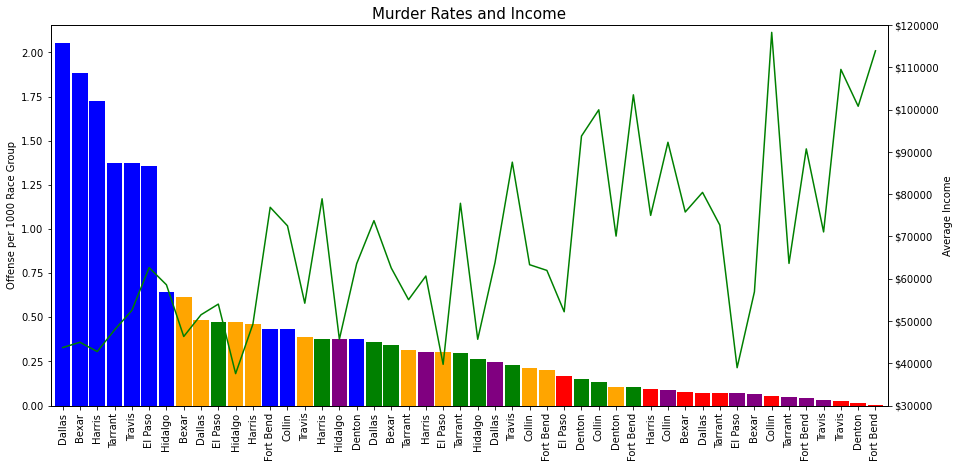

In [644]:
# Murder Plot by Income
murder_income_df = murder_income.sort_values(by = 'Offense_per_1000', ascending = False)
murder_income_df = murder_income_df.reset_index()

fig1, ax1= plt.subplots(figsize = (20,10))
ax2 = ax1.twinx()
width1 = 0.9
width2 = 0.2

ax1 = murder_income_df['Offense_per_1000'].plot(kind = 'bar', width = width1, figsize = (15,7), ax = ax1, color = col)
ax2 = murder_income_df['Average Income'].plot(kind = 'line', secondary_y = True, ax = ax2, color = 'g')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax2.yaxis.set_major_formatter(formatter)

plt.title('Murder Rates and Income', fontsize = '15')
ax1.set_ylabel('Offense per 1000 Race Group')
ax2.set_ylabel('Average Income')
plt.ylim((30000,120000))
ax1.set_xticklabels(murder_income_df["County"]);
plt.savefig('Murder_and_Income.png')

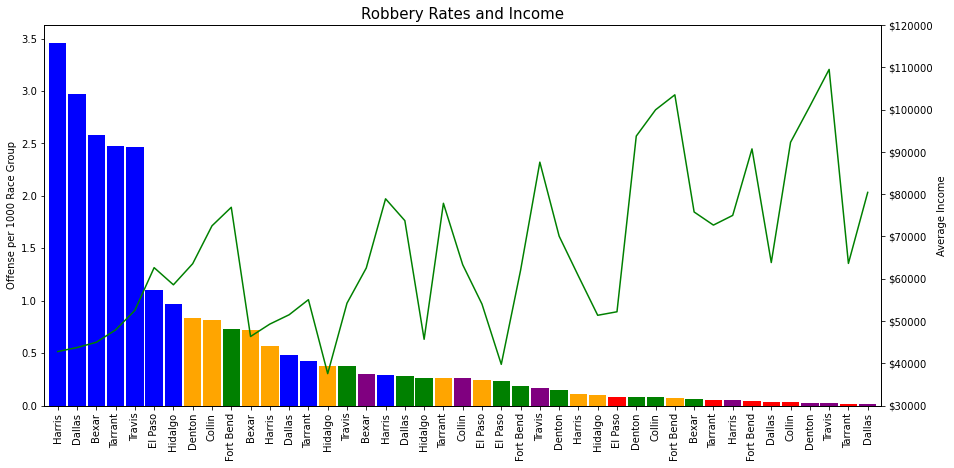

In [541]:
# Murder Plot by Income
robbery_income_df = robbery_income.sort_values(by = 'Offense_per_1000', ascending = False)
robbery_income_df = robbery_income_df.reset_index()

fig1, ax1 = plt.subplots(figsize = (20,10))
ax2 = ax1.twinx()
width1 = 0.9
width2 = 0.2

ax1 = robbery_income_df['Offense_per_1000'].plot(kind = 'bar', width = width1, figsize = (15,7), ax = ax1, color = col)
ax2 = robbery_income_df['Average Income'].plot(kind = 'line', secondary_y = True, ax = ax2, color = 'g')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax2.yaxis.set_major_formatter(formatter)

plt.title('Robbery Rates and Income', fontsize = '15')
plt.xticks(rotation='vertical')
ax1.set_ylabel('Offense per 1000 Race Group')
ax2.set_ylabel('Average Income')
plt.ylim((30000,120000))
ax1.set_xticklabels(robbery_income_df["County"]);
plt.savefig('Robbery_and_Income.png')

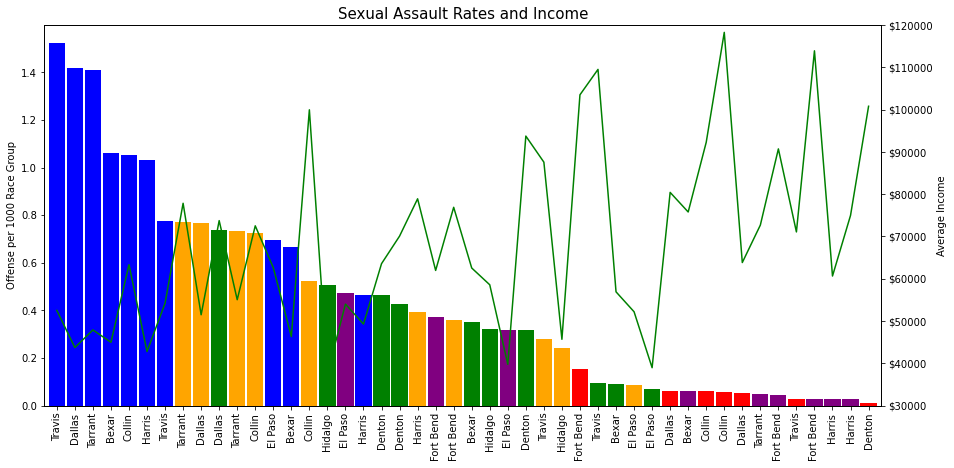

In [542]:
# Murder Plot by Income
sexassault_income_df = sexassault_income.sort_values(by = 'Offense_per_1000', ascending = False)
sexassault_income_df = sexassault_income_df.reset_index()

fig1, ax1 = plt.subplots(figsize = (20,10))
ax2 = ax1.twinx()
width1 = 0.9
width2 = 0.2

ax1 = sexassault_income_df['Offense_per_1000'].plot(kind = 'bar', width = width1, figsize = (15,7), ax = ax1, color = col)
ax2 = sexassault_income_df['Average Income'].plot(kind = 'line', secondary_y = True, ax = ax2, color = 'g')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax2.yaxis.set_major_formatter(formatter)

plt.title('Sexual Assault Rates and Income', fontsize = '15')
plt.xticks(rotation='vertical')
ax1.set_ylabel('Offense per 1000 Race Group')
ax2.set_ylabel('Average Income')
plt.ylim((30000,120000))
ax1.set_xticklabels(sexassault_income_df["County"]);
plt.savefig('SexAssault_and_Income.png')

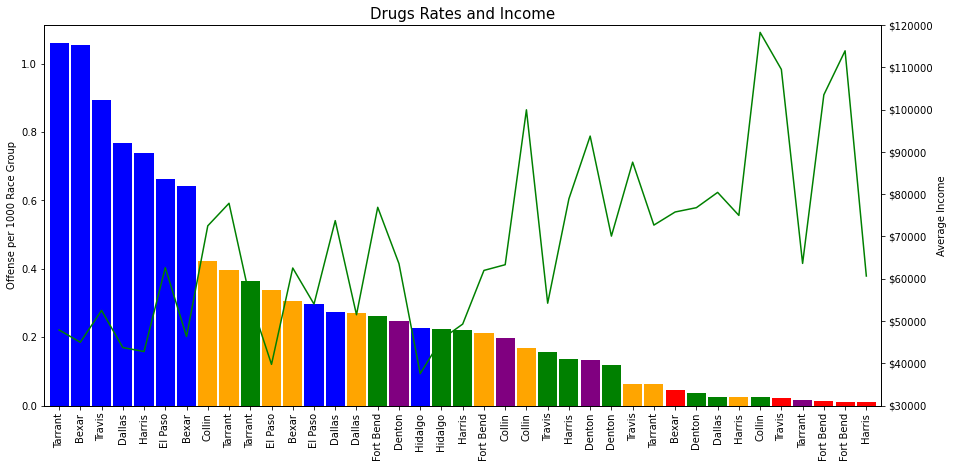

In [543]:
# Murder Plot by Income
drugs_income_df = drugs_income.sort_values(by = 'Offense_per_1000', ascending = False)
drugs_income_df = drugs_income_df.reset_index()

fig1, ax1 = plt.subplots(figsize = (20,10))
ax2 = ax1.twinx()
width1 = 0.9
width2 = 0.2

ax1 = drugs_income_df['Offense_per_1000'].plot(kind = 'bar', width = width1, figsize = (15,7), ax = ax1, color = col)
ax2 = drugs_income_df['Average Income'].plot(kind = 'line', secondary_y = True, ax = ax2, color = 'g')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax2.yaxis.set_major_formatter(formatter)

plt.title('Drugs Rates and Income', fontsize = '15')
plt.xticks(rotation='vertical')
ax1.set_ylabel('Offense per 1000 Race Group')
ax2.set_ylabel('Average Income')
plt.ylim((30000,120000))
ax1.set_xticklabels(drugs_income_df["County"]);
plt.savefig('Drugs_and_Income.png')

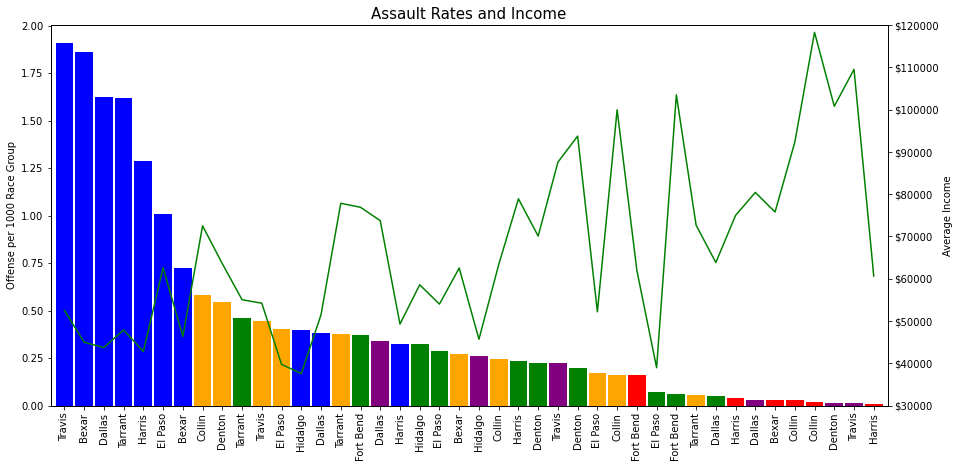

In [544]:
# Murder Plot by Income
assault_income_df = assault_income.sort_values(by = 'Offense_per_1000', ascending = False)
assault_income_df = assault_income_df.reset_index()

fig1, ax1 = plt.subplots(figsize = (20,10))
ax2 = ax1.twinx()
width1 = 0.9
width2 = 0.2

ax1 = assault_income_df['Offense_per_1000'].plot(kind = 'bar', width = width1, figsize = (15,7), ax = ax1, color = col)
ax2 = assault_income_df['Average Income'].plot(kind = 'line', secondary_y = True, ax = ax2, color = 'g')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax2.yaxis.set_major_formatter(formatter)

plt.title('Assault Rates and Income', fontsize = '15')
plt.xticks(rotation='vertical')
ax1.set_ylabel('Offense per 1000 Race Group')
ax2.set_ylabel('Average Income')
plt.ylim((30000,120000))
ax1.set_xticklabels(assault_income_df["County"]);
plt.savefig('Assault_and_Income.png')